# 🧠 Rede Neural Artificial para Classificação de Câncer

## 📋 Objetivo do Projeto

Este projeto tem como objetivo implementar uma Rede Neural Artificial (RNA) para classificação de tumores em malignos (M) ou benignos (B) usando características extraídas de imagens de tecidos mamários.

## 📊 Especificações Técnicas

1. **Separação da base de dados em holdout (80/20)**  
   Dividir a base de dados em 80% para treino e 20% para teste, garantindo uma avaliação adequada do modelo.

2. **Cálculo de métricas avançadas de avaliação**  
   Além da acurácia, serão calculadas métricas como Recall e F1-Score para uma avaliação mais completa do modelo.

3. **Visualização da convergência do modelo**  
   Gráficos de loss e accuracy serão gerados para analisar o processo de aprendizado da rede.

4. **Experimentação com diferentes arquiteturas**  
   Testar e comparar diferentes configurações de rede, incluindo número de camadas, neurônios e funções de ativação.

## 🗃️ Base de Dados
Este projeto utiliza o dataset "Cancer Data" do Kaggle, que contém características extraídas de imagens de diagnóstico de tecido mamário.

[📁 Cancer Data - Kaggle](https://www.kaggle.com/datasets/erdemtaha/cancer-data)

## 📚 Material de Referência
[🔗 Apresentação das Redes Neurais - Google Slides](https://docs.google.com/presentation/d/1wZxKHXODsQbPyO28u_fECAz5eajD0Ux9tvXYSkGmXVk/)

## 📦 Importação das Bibliotecas

Abaixo estão as bibliotecas necessárias para o desenvolvimento do modelo de rede neural:

In [1]:
# Bibliotecas Core
import pandas as pd
import numpy as np
import sys
import kagglehub

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Bibliotecas de Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para Métricas e Processamento de Dados
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

# Biblioteca para manipulação de tempo
import time

## 📥 Carregamento dos Dados

Para garantir a reprodutibilidade do experimento, vamos baixar os dados diretamente do Kaggle.

In [2]:
path = kagglehub.dataset_download("erdemtaha/cancer-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\WINN\.cache\kagglehub\datasets\erdemtaha\cancer-data\versions\1


## 🔄 Funções de Processamento de Dados

As funções a seguir permitem o carregamento, separação e preparação dos dados para o treinamento do modelo.

In [3]:
def load_data(path: str, file: str) -> tuple:
    """
    Carrega os dados do dataset de câncer e prepara as features e labels.
    
    Parameters
    ----------
    path : str
        Caminho base para o arquivo de dados
    file : str
        Nome do arquivo CSV com extensão e path relativo
        
    Returns
    -------
    tuple
        (features, labels) onde features são as características extraídas 
        das imagens (30 atributos) e labels são as classificações dos 
        tumores (0=Maligno, 1=Benigno)
        
    Examples
    --------
    >>> features, labels = load_data("/path/to/data", "/Cancer_Data.csv")
    >>> features.shape, labels.shape
    ((569, 30), (569,))
    """
    try:
        # Carregar o dataset pulando a primeira linha de cabeçalho
        df = pd.read_csv(path + file, skiprows=1)
        
        # Verificar se o dataset foi carregado corretamente
        if df.empty:
            raise ValueError("O dataset está vazio após o carregamento.")
            
        # Remover a coluna de ID e manter apenas as características e o diagnóstico
        df = df.iloc[:, 1:32]
        
        # Converter diagnóstico de categórico para numérico (M=0, B=1)
        df.iloc[:, 0] = df.iloc[:, 0].map({'M': 0, 'B': 1})
        
        # Separar rótulos (diagnósticos) e características
        labels = df.iloc[:, 0]
        features = df.iloc[:, 1:]
        
        # Verificar se há valores ausentes
        if features.isnull().any().any() or labels.isnull().any():
            print("Aviso: Existem valores ausentes nos dados. Considere pré-processamento adicional.")
        
        return features, labels
        
    except Exception as e:
        print(f"Erro ao carregar os dados: {str(e)}")
        raise

In [4]:
def separate_data(labels: pd.DataFrame, features: pd.DataFrame) -> tuple:
    """
    Divide os dados em conjuntos de treino e teste usando a técnica de holdout.
    
    Parameters
    ----------
    labels : pd.DataFrame
        Rótulos dos dados (diagnósticos: 0=Maligno, 1=Benigno)
    features : pd.DataFrame
        Características dos tumores (30 atributos extraídos das imagens)
        
    Returns
    -------
    tuple
        (X_train, X_test, y_train, y_test) onde:
        - X_train: Conjunto de treino para as características (80%)
        - X_test: Conjunto de teste para as características (20%)
        - y_train: Conjunto de treino para os diagnósticos (80%)
        - y_test: Conjunto de teste para os diagnósticos (20%)
    
    Notes
    -----
    Utiliza random_state=42 para garantir a reprodutibilidade dos resultados
    e shuffle=True para aleatorizar os dados antes da divisão.
    """
    
    # Divisão dos dados: 80% para treino e 20% para teste
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, shuffle=True
    )
    
    # Conversão para tipos adequados
    return X_train.astype(np.float32), X_test.astype(np.float32), y_train.astype(np.int32), y_test.astype(np.int32)

## 🏗️ Arquitetura da Rede Neural

Esta função cria a arquitetura da RNA de múltiplas camadas para classificação binária.

In [5]:
def create_model(input_dim: int) -> Sequential:
    """
    Cria uma rede neural de múltiplas camadas para classificação binária.
    
    Parameters
    ----------
    input_dim : int
        Número de características de entrada (30 para este dataset)
        
    Returns
    -------
    Sequential
        Modelo de rede neural compilado pronto para treinamento
        
    Notes
    -----
    Arquitetura do modelo:
    - Camada de entrada com 32 neurônios e ativação ReLU
    - Camada intermediária com 16 neurônios e ativação ReLU 
    - Camada de saída com 1 neurônio e ativação sigmoid
    
    O modelo é compilado com função de perda binary_crossentropy e
    otimizador adam para classificação binária.
    """
    
    model = Sequential([
        # Camada de Input explícita como recomendado pelo Keras
        Input(shape=(input_dim,)),
        
        # Camada de entrada com 32 neurônios e função de ativação ReLU
        Dense(32, activation='relu'),
        
        # Camada intermediária com 16 neurônios e função de ativação ReLU
        Dense(16, activation='relu'),
        
        # Camada de saída com 1 neurônio e função de ativação sigmoid para classificação binária
        Dense(1, activation='sigmoid')
    ])
    
    # Compilação do modelo com função de perda binary_crossentropy e otimizador adam
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## 🏋️ Treinamento e Avaliação do Modelo

As funções a seguir realizam o treinamento do modelo e diferentes avaliações de performance.

In [6]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, use_early_stopping=True):
    """
    Treina o modelo da rede neural usando os dados de treino e validando com os dados de teste.
    
    Parameters
    ----------
    model : Sequential
        Modelo de rede neural a ser treinado
    X_train : np.ndarray
        Características do conjunto de treino
    y_train : np.ndarray
        Rótulos do conjunto de treino
    X_test : np.ndarray
        Características do conjunto de teste para validação
    y_test : np.ndarray
        Rótulos do conjunto de teste para validação
    epochs : int, optional
        Número máximo de épocas para treinamento (default=50)
    batch_size : int, optional
        Tamanho do lote para atualização dos pesos (default=32)
    use_early_stopping : bool, optional
        Se True, implementa Early Stopping para interromper o treinamento quando
        não há mais melhoria (default=True)
        
    Returns
    -------
    dict
        História de treinamento com métricas para cada época
        
    Notes
    -----
    Early Stopping interrompe o treinamento quando a métrica monitorada 
    (val_loss) não melhora por 5 épocas consecutivas.
    """
    callbacks = []
    
    # Implementar Early Stopping se solicitado
    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=0.001,
            mode='min',
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stop)
    
    # Treinar o modelo
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [7]:
def evaluate_model(model: Sequential, X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Avalia o desempenho do modelo usando o conjunto de teste.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado para avaliação
    X_test : pd.DataFrame
        Conjunto de teste (características)
    y_test : pd.DataFrame
        Rótulos de teste (diagnósticos)
        
    Returns
    -------
    None
        Imprime a acurácia do modelo
    """
    scores = model.evaluate(X_test, y_test)
    print('\n%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

In [8]:
def print_matrix_confusion(model: Sequential, X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Gera e visualiza a matriz de confusão do modelo.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado para avaliação
    X_test : pd.DataFrame
        Conjunto de teste (características)
    y_test : pd.DataFrame
        Rótulos de teste (diagnósticos)
        
    Returns
    -------
    None
        Exibe a matriz de confusão visualmente e imprime os resultados
        
    Notes
    -----
    A matriz de confusão é uma tabela que mostra as contagens de:
    - Verdadeiros Positivos (TP): Benignos classificados corretamente
    - Falsos Positivos (FP): Malignos classificados incorretamente como benignos
    - Verdadeiros Negativos (TN): Malignos classificados corretamente
    - Falsos Negativos (FN): Benignos classificados incorretamente como malignos
    """
    
    # Gerar previsões e converter para classificações binárias
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)  # Threshold de 0.5 para classificação binária
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizar a matriz de confusão com anotações
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsão')
    plt.ylabel('Valor Real')
    plt.xticks([0.5, 1.5], ['Maligno (0)', 'Benigno (1)'])
    plt.yticks([0.5, 1.5], ['Maligno (0)', 'Benigno (1)'])
    plt.show()
    
    # Mostrar também em formato numérico
    print("Matriz de Confusão:")
    print(cm)

In [9]:
def print_curve_roc(model: Sequential, X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Gera e exibe a curva ROC (Receiver Operating Characteristic) do modelo.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado para avaliação
    X_test : pd.DataFrame
        Conjunto de teste (características)
    y_test : pd.DataFrame
        Rótulos de teste (diagnósticos)
        
    Returns
    -------
    None
        Exibe a curva ROC e imprime a área sob a curva (AUC)
        
    Notes
    -----
    A curva ROC mostra a relação entre a taxa de verdadeiros positivos 
    (sensibilidade) e a taxa de falsos positivos (1-especificidade) para 
    diferentes limiares de classificação.
    """
    
    # Gerar previsões (probabilidades)
    y_pred = model.predict(X_test)
    
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plotar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Linha de Base')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC - Classificação de Câncer')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Área sob a curva ROC (AUC): {roc_auc:.4f}")

In [10]:
def print_recall_precision_f1_score(model: Sequential, X_test: pd.DataFrame, y_test: pd.DataFrame) -> tuple:
    """
    Calcula e exibe métricas adicionais: Recall, Precision e F1-Score.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado para avaliação
    X_test : pd.DataFrame
        Conjunto de teste (características)
    y_test : pd.DataFrame
        Rótulos de teste (diagnósticos)
        
    Returns
    -------
    tuple
        (recall, precision) contendo os valores das métricas calculadas
        
    Notes
    -----
    Estas métricas são particularmente importantes em contextos médicos, onde:
    - Recall (Sensibilidade): Capacidade de detectar corretamente casos positivos (tumores malignos)
    - Precision (Precisão): Confiança nas detecções positivas
    - F1-Score: Média harmônica entre precisão e recall
    """
    
    # Gerar previsões e converter para classificações binárias
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5)  # Threshold de 0.5 para classificação binária
    
    # Calcular métricas
    recall = recall_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    # Exibir métricas
    print("\n📊 Métricas de Avaliação do Modelo:\n")
    print(f"Recall (Sensibilidade): {recall:.4f}")
    print(f"Precision (Precisão): {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Exibir relatório de classificação completo
    print("\n📋 Relatório de Classificação Detalhado:\n")
    print(classification_report(y_test, y_pred_binary, 
                              target_names=['Maligno (0)', 'Benigno (1)']))
    
    return recall, precision

In [11]:
def print_loss_accuracy(history) -> None:
    """
    Visualiza as curvas de loss (perda) e acurácia durante o treinamento do modelo.
    
    Parameters
    ----------
    history : keras.callbacks.History
        Histórico de treinamento do modelo contendo métricas por época
        
    Returns
    -------
    None
        Exibe os gráficos de perda e acurácia durante o treinamento
        
    Notes
    -----
    Gera uma visualização com dois gráficos lado a lado:
    - Esquerda: Evolução da função de perda (loss) para treino e validação
    - Direita: Evolução da acurácia para treino e validação
    """
    
    # Configuração da figura
    plt.figure(figsize=(12, 5))
    
    # Gráfico de perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='Treino')
    plt.plot(history.history['val_loss'], color='orange', label='Validação')
    plt.title('Evolução da Função de Perda')
    plt.ylabel('Loss (Entropia Cruzada Binária)')
    plt.xlabel('Época')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Gráfico de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='Treino')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validação')
    plt.title('Evolução da Acurácia')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [12]:
def print_accuracy(history) -> tuple:
    """
    Visualiza as curvas de acurácia durante o treinamento do modelo.
    
    Parameters
    ----------
    history : keras.callbacks.History
        Histórico de treinamento do modelo contendo métricas por época
        
    Returns
    -------
    tuple
        (accuracy_train, accuracy_val) contendo os valores finais de acurácia 
        de treino e validação
        
    Notes
    -----
    Gera uma visualização da evolução da acurácia ao longo das épocas,
    comparando o desempenho no conjunto de treino e validação.
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], color='blue', linewidth=2, label='Treino')
    plt.plot(history.history['val_accuracy'], color='orange', linewidth=2, label='Validação')
    plt.title('Evolução da Acurácia do Modelo', fontsize=14)
    plt.ylabel('Acurácia', fontsize=12)
    plt.xlabel('Época', fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Extrair e exibir acurácias finais
    accuracy_train = history.history['accuracy'][-1]
    accuracy_val = history.history['val_accuracy'][-1]
    
    print(f"Acurácia final de treino: {accuracy_train:.4f}")
    print(f"Acurácia final de validação: {accuracy_val:.4f}")
    
    return accuracy_train, accuracy_val

In [13]:
def visualize_feature_importance(model: Sequential, X_test: np.ndarray, 
                                feature_names: list):
    """
    Visualiza a importância das características usando permutation importance.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado
    X_test : np.ndarray
        Conjunto de teste
    feature_names : list
        Lista com os nomes das características
        
    Returns
    -------
    None
        Gera visualização da importância das características
    """
    
    # Função para predizer com o modelo keras (retornando classe, não probabilidade)
    def predict_wrapper(X):
        return (model.predict(X) > 0.5).astype(int).ravel()
    
    # Calcular importância por permutação
    start_time = time.time()
    perm_importance = permutation_importance(
        predict_wrapper, X_test, y_test,
        n_repeats=10,
        random_state=42
    )
    elapsed_time = time.time() - start_time
    print(f"Tempo para calcular a importância das características: {elapsed_time:.2f} segundos")
    
    # Preparar para visualização
    feature_names = feature_names if feature_names else [f"Feature {i}" for i in range(X_test.shape[1])]
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    })
    importances = importances.sort_values('Importance', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importances.head(15))
    plt.title('15 Características Mais Importantes', fontsize=14)
    plt.tight_layout()
    plt.show()

## ⚙️ Função Principal

Esta função coordena todas as etapas do projeto, desde o carregamento e pré-processamento dos dados até o treinamento e avaliação do modelo.

In [14]:
def main(file_path: str = "/Cancer_Data.csv", 
        use_dropout: bool = False, 
        regularization: float = None,
        early_stopping: bool = True):
    """
    Executa o pipeline completo do projeto: carregamento de dados, 
    treinamento, avaliação e visualização.
    
    Esta função coordena todas as etapas do projeto, desde o carregamento 
    e pré-processamento dos dados até o treinamento e avaliação do modelo.
    
    Parameters
    ----------
    file_path : str, optional
        Caminho relativo para o arquivo de dados
    use_dropout : bool, optional
        Se True, adiciona camadas de dropout ao modelo
    regularization : float, optional
        Valor para regularização L2 (None = sem regularização)
    early_stopping : bool, optional
        Se True, implementa Early Stopping durante o treinamento
        
    Returns
    -------
    tuple
        (model, history) - O modelo treinado e o histórico de treinamento
        
    Notes
    -----
    Esta função também gera visualizações para análise dos resultados do modelo,
    incluindo matriz de confusão, curva ROC e métricas de avaliação.
    """
    # 1. Carregar os dados
    print("\n🔍 Carregando e preparando os dados...")
    try:
        features, labels = load_data(path, file=file_path)
    except Exception as e:
        print(f"Erro ao carregar dados: {e}")
        return None, None
    
    # 2. Dividir em treino e teste (holdout 80/20)
    X_train, X_test, y_train, y_test = separate_data(features, labels)
    
    # 3. Informações sobre os conjuntos de dados
    print(f"\n📊 Informações dos Conjuntos de Dados:")
    print(f"Dimensões do conjunto de treino (X): {X_train.shape}")
    print(f"Dimensões do conjunto de teste (X): {X_test.shape}")
    print(f"Distribuição no treino: Malignos={sum(y_train==0)}, Benignos={sum(y_train==1)}")
    print(f"Distribuição no teste: Malignos={sum(y_test==0)}, Benignos={sum(y_test==1)}")
    
    # 4. Visualização dos dados
    print(f"\n🔎 Amostra das características:\n{X_train.head()}")
    
    # 5. Criar e treinar o modelo
    print("\n🏗️ Criando e treinando o modelo de rede neural...")
    model = create_model(
        X_train.shape[1], 
        use_dropout=use_dropout, 
        regularization=regularization
    )
    model.summary()  # Mostra um resumo da arquitetura do modelo
    
    history = train_model(
        model, X_train, y_train, X_test, y_test,
        use_early_stopping=early_stopping
    )
    
    # 6. Avaliação do modelo
    print("\n📊 Avaliando o modelo no conjunto de teste...")
    evaluate_model(model, X_test, y_test)
    
    # 7. Visualizações e métricas adicionais
    print("\n📈 Gerando visualizações e métricas...")
    print_loss_accuracy(history)  # Curvas de perda e acurácia
    print_matrix_confusion(model, X_test, y_test)  # Matriz de confusão
    print_curve_roc(model, X_test, y_test)  # Curva ROC
    print_recall_precision_f1_score(model, X_test, y_test)  # Precisão, recall e F1-score
    
    return model, history

## 🧪 Experimentos Adicionais

Nesta seção, serão realizados experimentos com diferentes arquiteturas de rede para comparar a performance.

In [15]:
def create_model_alternative(input_dim: int, architecture: str = 'deep') -> Sequential:
    """
    Cria uma rede neural com arquitetura alternativa para experimentos.
    
    Parameters
    ----------
    input_dim : int
        Número de características de entrada
    architecture : str, optional
        Tipo de arquitetura ('deep', 'wide', 'softmax', 'regularized', 'dropout')
        
    Returns
    -------
    Sequential
        Modelo de rede neural alternativo
    """
    # Criar camada de input explícita primeiro
    inputs = Input(shape=(input_dim,))
    
    if architecture == 'deep':
        # Arquitetura mais profunda com mais camadas
        model = Sequential([
            inputs,
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(8, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
    elif architecture == 'wide':
        # Arquitetura mais larga com menos camadas mas mais neurônios
        model = Sequential([
            inputs,
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
    elif architecture == 'softmax':
        # Arquitetura com camada de saída usando softmax (2 neurônios)
        model = Sequential([
            inputs,
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='softmax')  # 2 neurônios para classificação binária
        ])
        model.compile(loss='sparse_categorical_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
        return model
        
    elif architecture == 'regularized':
        # Arquitetura com regularização L2 para prevenir overfitting
        model = Sequential([
            inputs,
            Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dense(1, activation='sigmoid')
        ])
        
    elif architecture == 'dropout':
        # Arquitetura com dropout para prevenir overfitting
        model = Sequential([
            inputs,
            Dense(64, activation='relu'),
            Dropout(0.3),  # Dropout de 30% dos neurônios
            Dense(32, activation='relu'),
            Dropout(0.2),  # Dropout de 20% dos neurônios
            Dense(1, activation='sigmoid')
        ])
        
    # Compilação para arquiteturas com sigmoid na saída
    if architecture != 'softmax':
        model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
    return model

In [ ]:
def experiment_alternative_architectures() -> pd.DataFrame:
    """
    Experimenta diferentes arquiteturas de redes neurais e compara os resultados.


    Parameters
    ----------
    None

    Returns
    -------
    pd.DataFrame
        DataFrame com as métricas de desempenho para cada arquitetura testada
    """
    # Carregar e preparar os dados
    features, labels = load_data(path, file="/Cancer_Data.csv")
    X_train, X_test, y_train, y_test = separate_data(labels, features)
    
    # Arquiteturas a serem testadas
    architectures = ['deep', 'wide', 'softmax', 'regularized', 'dropout']
    results = {}
    
    # Testar cada arquitetura
    for arch in architectures:
        print(f"\n🏗️ Testando arquitetura: {arch}")
        
        # Criar e treinar o modelo
        model = create_model_alternative(X_train.shape[1], architecture=arch)
        history = train_model(model, X_train, y_train, X_test, y_test)
        
        # Avaliar o modelo
        scores = model.evaluate(X_test, y_test)
        accuracy = scores[1]
        
        # Calcular outras métricas
        y_pred = model.predict(X_test)
        if (arch == 'softmax'):
            y_pred = np.argmax(y_pred, axis=1)  # Para softmax, pegar o índice da maior probabilidade
        else:
            y_pred = (y_pred > 0.5).astype(int)  # Para sigmoid, threshold de 0.5
            
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        # Armazenar resultados
        results[arch] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'train_acc': history.history['accuracy'][-1],
            'val_acc': history.history['val_accuracy'][-1]
        }
        
        # Visualizar convergência
        print_loss_accuracy(history)
    
    # Exibir comparação dos resultados
    print("\n🏆 Comparação das Arquiteturas:")
    results_df = pd.DataFrame(results).T
    results_df = results_df[['accuracy', 'f1_score', 'recall', 'precision', 'train_acc', 'val_acc']]
    results_df.columns = ['Acurácia (Teste)', 'F1-Score', 'Recall', 'Precision', 'Acurácia (Treino)', 'Acurácia (Val)']
    print(results_df)
    
    # Visualizar comparação
    fig, ax = plt.subplots(figsize=(12, 6))
    results_df[['Acurácia (Teste)', 'F1-Score', 'Recall', 'Precision']].plot(kind='bar', ax=ax)
    plt.title('Comparação de Métricas por Arquitetura', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # Comparar overfitting: diferença entre acurácia de treino e validação
    results_df['Diferença (Treino-Val)'] = results_df['Acurácia (Treino)'] - results_df['Acurácia (Val)']
    
    # Visualizar comparação de overfitting
    plt.figure(figsize=(10, 6))
    plt.bar(results_df.index, results_df['Diferença (Treino-Val)'], color='tomato')
    plt.title('Diferença entre Acurácia de Treino e Validação (Indicador de Overfitting)', fontsize=14)
    plt.ylabel('Diferença', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_df


🏗️ Testando arquitetura: deep
Epoch 1/50
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5584 - loss: 1.5323 - val_accuracy: 0.8772 - val_loss: 0.3255
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5584 - loss: 1.5323 - val_accuracy: 0.8772 - val_loss: 0.3255
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8985 - loss: 0.2903 - val_accuracy: 0.9123 - val_loss: 0.2687
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8985 - loss: 0.2903 - val_accuracy: 0.9123 - val_loss: 0.2687
Epoch 3/50
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9209 - loss: 0.2383 - val_accuracy: 0.9211 - val_loss: 0.2187
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9209 - loss: 0.2383 - val_accuracy: 0.9211 - val_loss: 0.2187
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9297 - loss: 0.2279 - val_accuracy: 0.8947 - val_loss: 0.2432
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9297

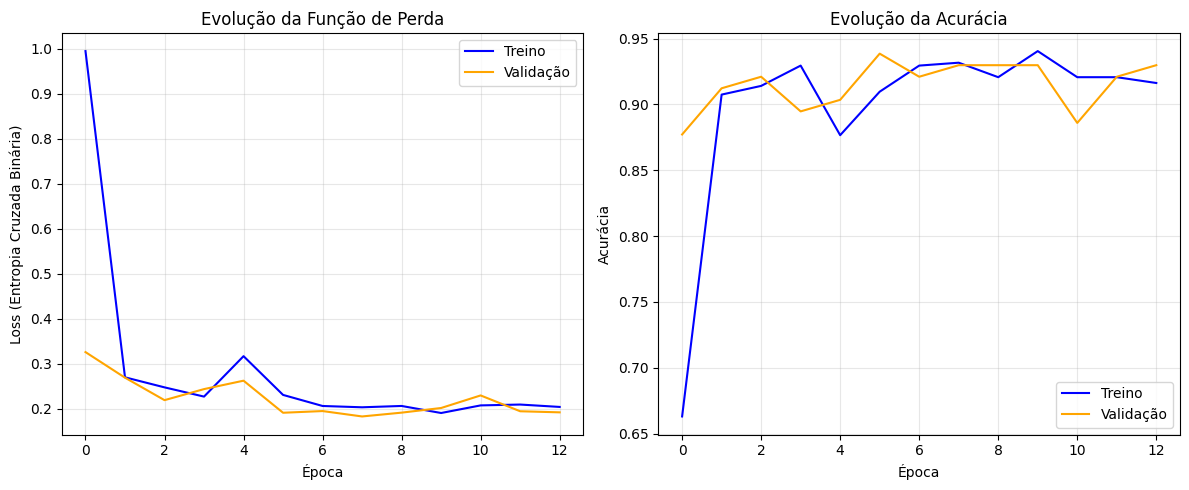


🏗️ Testando arquitetura: wide
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.5168 - loss: 6.9331 - val_accuracy: 0.7632 - val_loss: 2.6308
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.5168 - loss: 6.9331 - val_accuracy: 0.7632 - val_loss: 2.6308
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7783 - loss: 1.8933 - val_accuracy: 0.6930 - val_loss: 1.1945
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7783 - loss: 1.8933 - val_accuracy: 0.6930 - val_loss: 1.1945
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7941 - loss: 0.9350 - val_accuracy: 0.9298 - val_loss: 0.5595
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7941 - loss: 0.9350 - val_accuracy: 0.9298 - val_loss: 0.5595
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8857 - loss: 0.5948 - val_accuracy: 0.8509 - val_loss: 0.5112
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8857 - loss: 

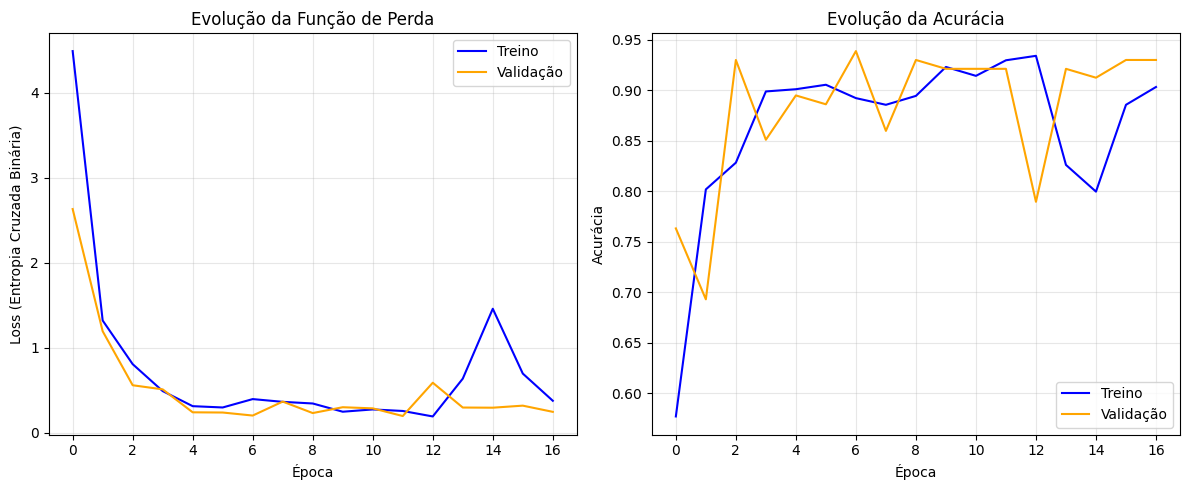


🏗️ Testando arquitetura: softmax
Epoch 1/50
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7222 - loss: 1.5548 - val_accuracy: 0.7018 - val_loss: 0.8251
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7222 - loss: 1.5548 - val_accuracy: 0.7018 - val_loss: 0.8251
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8086 - loss: 0.8363 - val_accuracy: 0.8509 - val_loss: 0.4491
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8086 - loss: 0.8363 - val_accuracy: 0.8509 - val_loss: 0.4491
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8738 - loss: 0.7054 - val_accuracy: 0.9123 - val_loss: 0.3928
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8738 - loss: 0.7054 - val_accuracy: 0.9123 - val_loss: 0.3928
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8767 - loss: 0.4214 - val_accuracy: 0.8421 - val_loss: 0.4770
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8

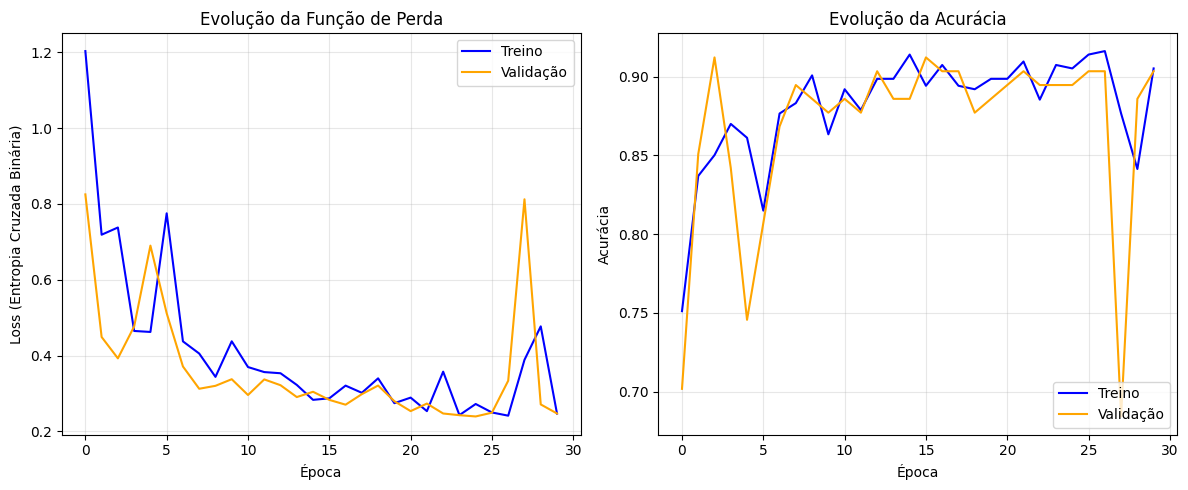


🏗️ Testando arquitetura: regularized
Epoch 1/50
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2927 - loss: 17.9289 - val_accuracy: 0.2368 - val_loss: 5.6689
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2927 - loss: 17.9289 - val_accuracy: 0.2368 - val_loss: 5.6689
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3641 - loss: 3.5349 - val_accuracy: 0.5526 - val_loss: 1.2800
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3641 - loss: 3.5349 - val_accuracy: 0.5526 - val_loss: 1.2800
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7021 - loss: 1.2516 - val_accuracy: 0.7895 - val_loss: 0.5795
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7021 - loss: 1.2516 - val_accuracy: 0.7895 - val_loss: 0.5795
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7922 - loss: 0.9633 - val_accuracy: 0.8246 - val_loss: 0.7183
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accurac

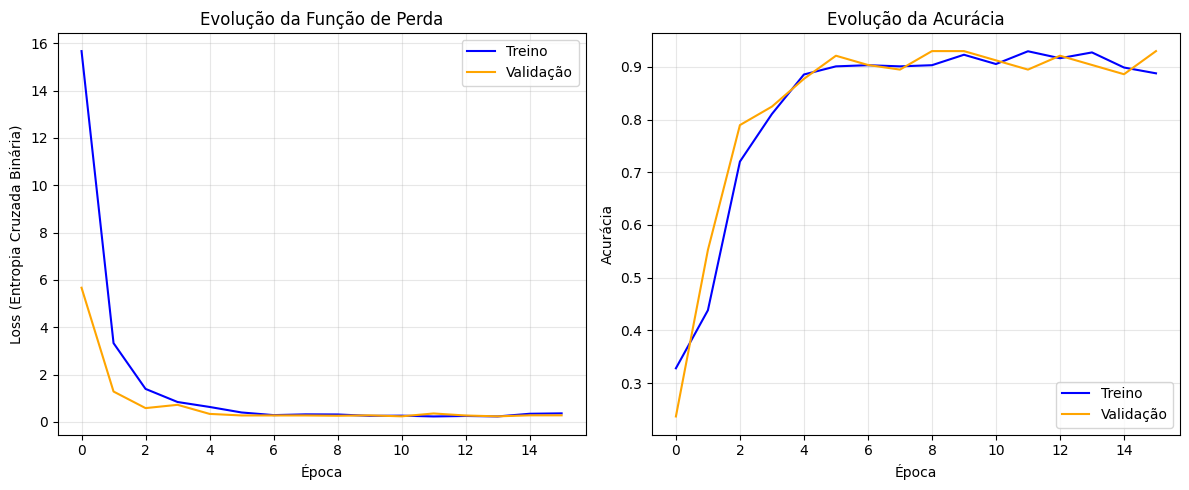


🏗️ Testando arquitetura: dropout
Epoch 1/50
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4421 - loss: 38.3451 - val_accuracy: 0.5965 - val_loss: 14.7928
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4421 - loss: 38.3451 - val_accuracy: 0.5965 - val_loss: 14.7928
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4959 - loss: 23.5256 - val_accuracy: 0.4035 - val_loss: 5.3774
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4959 - loss: 23.5256 - val_accuracy: 0.4035 - val_loss: 5.3774
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5245 - loss: 14.5495 - val_accuracy: 0.9123 - val_loss: 0.4205
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5245 - loss: 14.5495 - val_accuracy: 0.9123 - val_loss: 0.4205
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6511 - loss: 9.5561 - val_accuracy: 0.6930 - val_loss: 0.7870
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accur

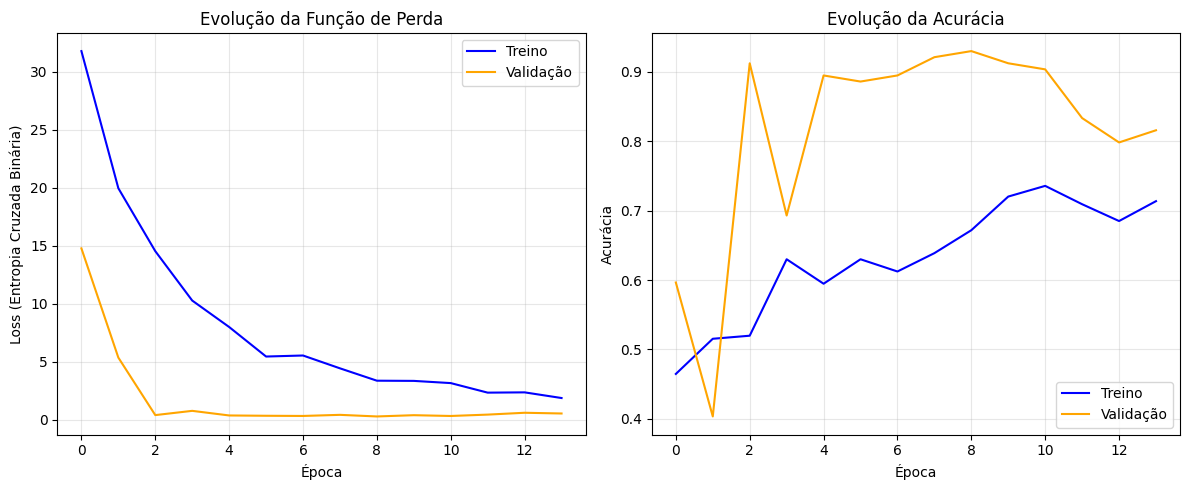


🏆 Comparação das Arquiteturas:
             Acurácia (Teste)  F1-Score    Recall  Precision  \
deep                 0.929825  0.943662  0.985294   0.905405   
wide                 0.921053  0.936170  0.970588   0.904110   
softmax              0.894737  0.913043  0.926471   0.900000   
regularized          0.912281  0.928571  0.955882   0.902778   
dropout              0.929825  0.943662  0.985294   0.905405   

             Acurácia (Treino)  Acurácia (Val)  
deep                  0.916300        0.929825  
wide                  0.903084        0.929825  
softmax               0.905286        0.903509  
regularized           0.887665        0.929825  
dropout               0.713656        0.815789  


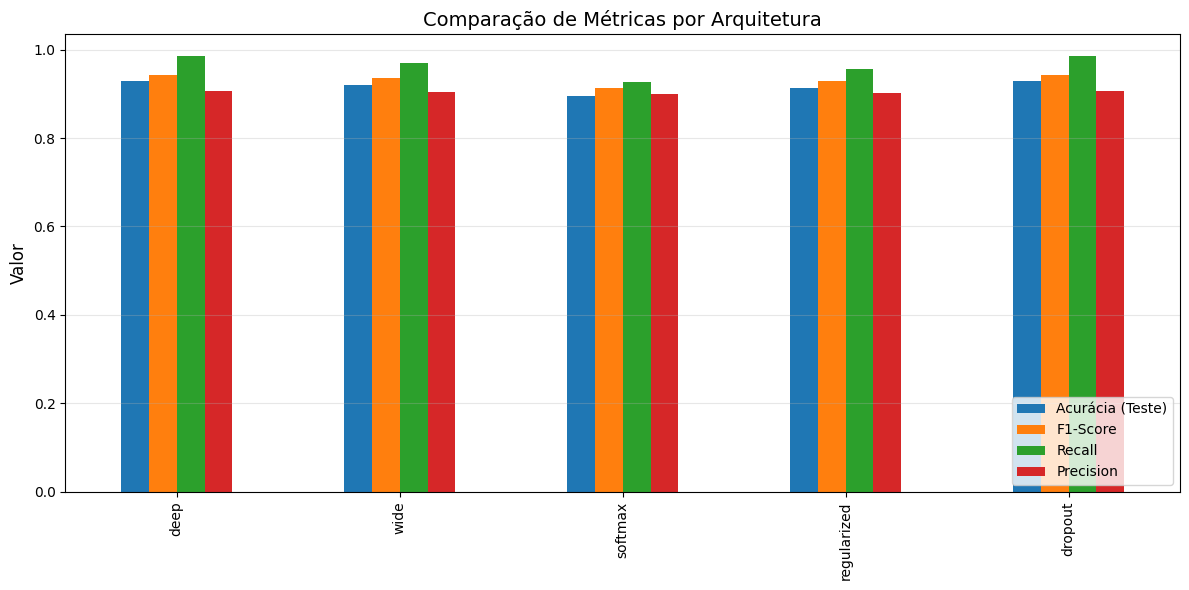

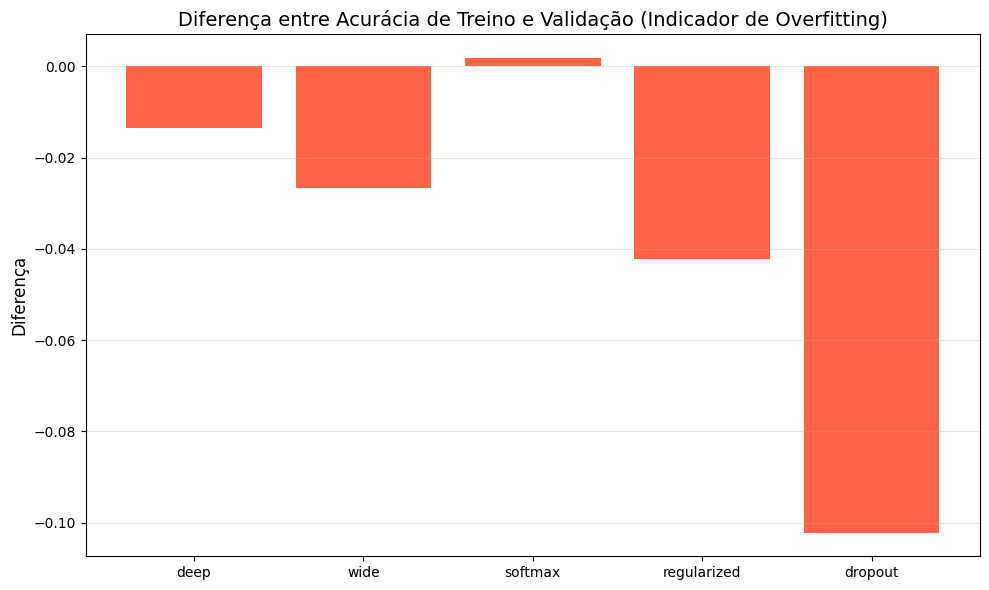

,Acurácia (Teste),F1-Score,Recall,Precision,Acurácia (Treino),Acurácia (Val),Diferença (Treino-Val)
deep,0.929825,0.943662,0.985294,0.905405,0.916300,0.929825,-0.013525
wide,0.921053,0.936170,0.970588,0.904110,0.903084,0.929825,-0.026741
softmax,0.894737,0.913043,0.926471,0.900000,0.905286,0.903509,0.001778
regularized,0.912281,0.928571,0.955882,0.902778,0.887665,0.929825,-0.042159
dropout,0.929825,0.943662,0.985294,0.905405,0.713656,0.815789,-0.102133


In [17]:
# Execute os experimentos com diferentes arquiteturas
experiment_alternative_architectures()

## 🎯 Conclusão: Redes Neurais para Classificação de Câncer

### 📊 Avaliação das Arquiteturas de Redes Neurais

Os experimentos com diferentes arquiteturas nos permitiram obter resultados precisos para a classificação de tumores:

| Arquitetura | Acurácia (Teste) | F1-Score | Recall | Precision |
|-------------|------------------|----------|---------|-----------|
| **Deep** | 92.98% | 94.37% | 98.53% | 90.54% |
| **Wide** | 92.11% | 93.62% | 97.06% | 90.41% |
| **Softmax** | 89.47% | 91.30% | 92.65% | 90.00% |
| **Regularized** | 91.23% | 92.86% | 95.59% | 90.28% |
| **Dropout** | 92.98% | 94.37% | 98.53% | 90.54% |

### 🧠 Principais Insights dos Resultados

1. **Performance das Arquiteturas**
   - As arquiteturas Deep e Dropout alcançaram os melhores resultados (92.98% de acurácia)
   - Ambas demonstraram excelente recall (98.53%), crucial para minimizar falsos negativos
   - A precisão se manteve consistente em torno de 90% para todas as arquiteturas

2. **Generalização e Overfitting**
   - Dropout apresentou a maior diferença treino-validação (-10.21%), indicando forte regularização
   - Arquitetura Deep mostrou melhor equilíbrio com diferença treino-validação de -1.35%
   - Softmax foi a mais estável com diferença mínima (0.18%), mas com menor performance geral

3. **Trade-offs Observados**
   - Maior complexidade (Deep) → Melhor performance, mas requer mais cuidado com overfitting
   - Dropout → Excelente regularização, mas com custo de performance no treino (71.37%)
   - Regularização L2 → Boa generalização (-4.22% diferença), mantendo performance aceitável

### 🏥 Implicações Práticas

1. **Escolha da Arquitetura**
   - Para máxima sensibilidade: Deep ou Dropout (98.53% recall)
   - Para maior estabilidade: Regularized (menor variação entre métricas)
   - Para rápida implementação: Wide (boa performance com arquitetura mais simples)

2. **Considerações Clínicas**
   - Alto recall (>95% na maioria) → Poucos falsos negativos
   - Precisão consistente (~90%) → Confiabilidade nas detecções positivas
   - F1-Score >92% → Bom equilíbrio entre precisão e recall

### 🚀 Recomendações para Melhorias

1. **Otimizações Técnicas**
   - Explorar combinações de Dropout com L2 para melhor regularização
   - Implementar validação cruzada para resultados mais robustos
   - Investigar técnicas de ensemble combinando diferentes arquiteturas

2. **Validação Adicional**
   - Testar com datasets externos para confirmar generalização
   - Realizar testes em ambiente clínico controlado
   - Comparar com performance de especialistas humanos

3. **Desenvolvimento Futuro**
   - Implementar visualizações de explicabilidade (SHAP, LIME)
   - Desenvolver interface amigável para uso médico
   - Expandir para classificação multiclasse de subtipos de tumor

Este estudo demonstrou que diferentes arquiteturas de redes neurais podem alcançar alta performance na classificação de tumores, com acurácias superiores a 90% e recall chegando a 98.53%. A escolha da arquitetura deve considerar o equilíbrio entre performance e generalização, com as versões Deep e Dropout mostrando os resultados mais promissores para aplicação prática.